In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt                        
%matplotlib inline 

import cv2
from glob import glob

## About Data
We have train data and test data of images.
* Images are about plant seedlings at various stages of grown.
* Each image has a filename that is its unique id. 
* The dataset comprises 12 plant species. 

The list of species is as follows:
- Black-grass = WEED
- Charlock = PLANT
- Cleavers = WEED
- Common Chickweed = WEED
- Common wheat = PLANT
- Fat Hen = WEED
- Loose Silky-bent = PLANT
- Maize = PLANT
- Scentless Mayweed = WEED 
- Shepherds Purse = WEED
- Small-flowered Cranesbill = WEED
- Sugar beet = PLANT

### Train data loading & labeling

In [4]:

images_path = '/kaggle/input/plant-seedlings-classification/train/*/*.png'
images = glob(images_path) #to return all file paths that match a specific pattern

train_images = []
train_labels = []

for img in images:
    train_images.append(cv2.resize(cv2.imread(img), (256, 256))) #image is 256x256x3
    train_labels.append(img.split('/')[-2])
    
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [5]:
plt.imshow(train_X[1])

In [6]:
train_Y.sample(5)

In [7]:
train_Y.info()

In [8]:
train_Y.rename(columns={0:'species'},inplace=True)

In [9]:
train_Y.species.unique()

In [10]:
plants_type = {
    'Scentless Mayweed': 1, 
    'Common wheat': 0, 
    'Charlock': 0, 
    'Black-grass': 1,
    'Sugar beet': 0, 
    'Loose Silky-bent': 0, 
    'Maize': 0, 
    'Cleavers': 1,
    'Common Chickweed': 1, 
    'Fat Hen': 1, 
    'Small-flowered Cranesbill': 1,
    'Shepherds Purse': 1
}

In [11]:
plants_type['Fat Hen']

In [12]:
plt.figure(figsize=(10,5))

chart = sns.countplot(
    data=train_Y,
    x='species'
)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [13]:
train_X.shape #4750 images, width,height: 256, RGB color

In [14]:
train_Y['species'].value_counts()

### LabelEncoding Target

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
le.fit(train_Y['species'])
encoded_labels = le.transform(train_Y['species'])
train_label = np_utils.to_categorical(encoded_labels) #Data type: Number to Binary

In [16]:
encoded_labels

In [17]:
train_label

In [18]:
#seed fixing
import random
import os
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

### Train Data & Validation Data 
I used stratify option to solve class imbalance problem.
This will be used by the train_test_split() function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array.

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, 
                                                 train_label, 
                                                 test_size=0.2,
                                                 random_state=seed, 
                                                 stratify=train_label)

In [20]:
# Normalization of the Image Data (for grey scaling)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

In [21]:
plt.imshow(X_train[1])

### ImageDataGenerator = Data Augmentation


In [22]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

### Build Model

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(256, 256, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

model.summary()

[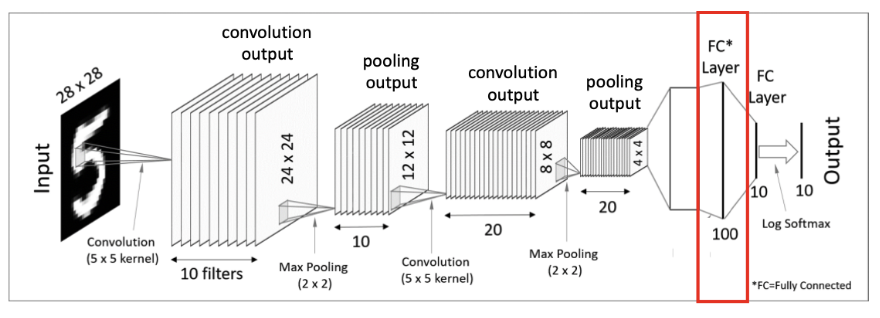](http://)

In [24]:
#Specify Loss and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#where to save the model
model_checkpoint = ModelCheckpoint('/kaggle/working/plantspecies_CNN_model.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

#Stop fitting if there's no enhancement of accuracy for 10 times.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

### Fit Model

In [26]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=8), 
                    epochs=30, validation_data=(X_test, y_test),   
                    callbacks = [early_stopping, model_checkpoint])

### Prediction

In [80]:
predictions = model.predict(X_test)

In [86]:
# Confidences of each class!
predictions[0]

In [87]:
# Predicted label
np.argmax(predictions[0])

In [88]:
pred_class = np.argmax(predictions, axis=1)
actual_class = np.argmax(y_test, axis=1)

pred_str = le.classes_[pred_class]
actual_str = le.classes_[actual_class]

final_pred = {
    'actual': actual_str, 
    'predicted': pred_str
}

final_pred = pd.DataFrame(final_pred)

In [89]:
final_pred.sample(10)

## Evaluate the model

In [90]:
#Final score and accuracy of the model
score, acc = model.evaluate(X_test, y_test)

In [91]:
print('Validation score:', score,'\nValidation accuracy:', acc)

In [125]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report: \n')
print(classification_report(
    y_true = actual_class, 
    y_pred = pred_class,
    output_dict=False,
    target_names=le.classes_))

In [123]:
import itertools

# Inspired from scikit-learn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [124]:
plt.subplots(figsize=(22,9)) #set the size of the plot 

cmatrix = confusion_matrix(actual_class, pred_class)
plot_confusion_matrix(cmatrix, classes = le.classes_)